In [1]:
import torch, torchvision
import torch.nn as nn

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

import detectron2
from detectron2.modeling import BACKBONE_REGISTRY, Backbone, ShapeSpec
import detectron2.data.transforms as T
from detectron2.data.transforms import Transform
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader
from detectron2.modeling import build_model,build_resnet_backbone,build_backbone
from detectron2.structures import ImageList, Instances
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling.meta_arch.rcnn import GeneralizedRCNN
from detectron2.evaluation import COCOEvaluator
from detectron2.data.datasets import register_coco_instances
from segmentation_models_pytorch.encoders import get_encoder

from transformations import *

from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

## Transformation Functions

- Contrast normalization: The myeloma cells have varying levels of contrast as compared to other cells and tissues, so normalizing the contrast can help them be more visible
- Morphological operations: Erosion or dilation operations can smooth the edges of the cells can help us detect the cancer cells better
- Gradient Filters: Sobel filter can help identify the boundaries of the cells better
- Color Channels: Manipulate the different color channels (RGB) of the image by suppressing or enhancing the effect of either red, green, or blue channel
- Gaussian Blur Filter: Try the Gaussian blur filters to smooth the image and reduce the noise

In [2]:
def select_transformation(transformation_type=None):
    """
    Define the type of augmentation to apply to the images.
    
    Args:
    
    """
    if transformation_type is None:
        transformation = NoOpTransform()
        
    else:
        transformation = eval(transformation_type + "()")
    
    return [transformation]

In [3]:
def test_transformation(img_path="../TCIA_SegPC_dataset/coco/x/106.bmp", transformation_type=None):
    """
    Display the transformation on the image
    
    """
    
    ## Read the image
    img = cv2.imread(img_path)
    
    ## Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ## Get the image transformer
    transform_object = select_transformation(transformation_type)[0]
    
    ## APply transformation
    img_transformed = transform_object.apply_image(img)
    
    ## Create a figure with two subplots in a single row
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    ## Display the first image in the first subplot
    axs[0].imshow(img)
    axs[0].set_title('Original Image')

    ## Display the second image in the second subplot
    axs[1].imshow(img_transformed)
    axs[1].set_title('Transformed Image')

    ## Show the figure
    plt.show();

## Model Architecture

In [4]:
# Define netowrk architecture
@BACKBONE_REGISTRY.register()
class Effb5(Backbone):
    def __init__(self, cfg, input_shape):
        super().__init__()
        
        # Set up the illumination layer
#         self.illumination = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=1, stride=1, padding=0, bias=False)
#         torch.nn.init.normal_(self.illumination.weight, mean=0.0, std=0.05)
#         in_channels = 1
        
        in_channels = 3
        encoder_name = 'timm-efficientnet-b5'
        encoder_depth = 5
        encoder_weights = 'noisy-student'
        self.encoder = get_encoder(encoder_name,
                in_channels=in_channels,
                depth=encoder_depth,
                weights=encoder_weights)
        self.channels = self.encoder.out_channels
        self.conv = nn.ModuleList(
            [nn.Conv2d(self.channels[i],256,3,stride = 2, padding = 1) for i in range(len(self.channels))]
        )

        self.names = ["p"+str(i+1) for i in range(6)]
        
    def forward(self, image):

#         illuminated_image = torch.sum(self.illumination(image), dim=1, keepdim=True)
#         features = self.encoder(illuminated_image)
        features = self.encoder(image)
        out = {self.names[i]: self.conv[i](features[i]) for i in range(1, len(features))}

        return out
    def output_shape(self):
        out_shape = {self.names[i]: ShapeSpec(channels =256, stride = 2**(i+1)) for i in range(1, len(self.names))}
        return out_shape

## Model Training Class

In [5]:
class CocoTrainer(DefaultTrainer):
    """
    Custom class for model training
    """
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
            
        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    
    @classmethod
    def build_train_loader(cls, cfg):
        
        mapper = DatasetMapper(cfg, is_train=True, augmentations=select_transformation(TRANSFORM_TYPE))
        
        return build_detection_train_loader(cfg, mapper=mapper)
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        
        mapper = DatasetMapper(cfg, is_train=False, augmentations=select_transformation(TRANSFORM_TYPE))
        
        return build_detection_test_loader(cfg, dataset_name, mapper=mapper)
    

## Dataset Initialization

In [6]:
register_coco_instances("SegPC_train", {}, "../TCIA_SegPC_dataset/coco/COCO.json", "../TCIA_SegPC_dataset/coco/x/")
register_coco_instances("SegPC_val", {}, "../TCIA_SegPC_dataset/coco_val/COCO.json", "../TCIA_SegPC_dataset/coco_val/x/")

train_meta = MetadataCatalog.get('SegPC_train')
val_meta = MetadataCatalog.get('SegPC_val')

train_dicts = DatasetCatalog.get("SegPC_train")
val_dicts = DatasetCatalog.get("SegPC_val")

[04/29 22:45:17 d2.data.datasets.coco]: Loaded 298 images in COCO format from ../TCIA_SegPC_dataset/coco/COCO.json
[04/29 22:45:17 d2.data.datasets.coco]: Loaded 200 images in COCO format from ../TCIA_SegPC_dataset/coco_val/COCO.json


## Configuration Setup

In [7]:
## Initialize model configuration
cfg = get_cfg()

## Set parameters
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"))
cfg.DATASETS.TRAIN = ("SegPC_train",)
cfg.DATASETS.TEST = ("SegPC_val",)

cfg.DATALOADER.NUM_WORKERS = 5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02/8
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'

cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.MAX_ITER = 3725
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 250
cfg.MODEL.BACKBONE.NAME = "Effb5"

cfg.CUDNN_BENCHMARK = True
cfg.OUTPUT_DIR = "./output_sobel_filter/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

TRANSFORM_TYPE = "SobelFilter" 

# CorrectColor, ContrastNormalization, Dilation, Erosion
# EnhanceRedColor, EnhanceGreenColor, EnhanceBlueColor,
# MedianFilter, GaussianBlur, SobelFilter

## Testing Trasformation Results

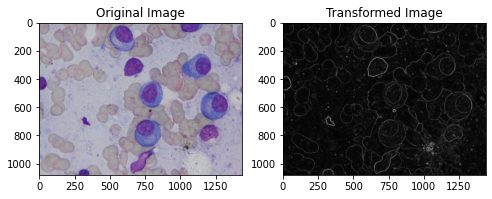

In [8]:
test_transformation(transformation_type=TRANSFORM_TYPE)

## Train The Model

In [ ]:
## Train the model
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/29 22:45:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): Effb5(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
       

Skip loading parameter 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.2.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) 

[04/29 22:45:46 d2.engine.train_loop]: Starting training from iteration 0


/hpc/home/ak704/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/29 22:45:58 d2.utils.events]:  eta: 0:35:29  iter: 19  total_loss: 3.975  loss_cls_stage0: 0.5802  loss_box_reg_stage0: 0.7771  loss_cls_stage1: 0.5461  loss_box_reg_stage1: 0.448  loss_cls_stage2: 0.4799  loss_box_reg_stage2: 0.1943  loss_mask: 0.6898  loss_rpn_cls: 0.3442  loss_rpn_loc: 0.09124  time: 0.5757  data_time: 0.0331  lr: 0.00047618  max_mem: 26030M
[04/29 22:46:09 d2.utils.events]:  eta: 0:35:28  iter: 39  total_loss: 3.466  loss_cls_stage0: 0.4989  loss_box_reg_stage0: 0.907  loss_cls_stage1: 0.3419  loss_box_reg_stage1: 0.5524  loss_cls_stage2: 0.2067  loss_box_reg_stage2: 0.2053  loss_mask: 0.6192  loss_rpn_cls: 0.06736  loss_rpn_loc: 0.05091  time: 0.5781  data_time: 0.0180  lr: 0.00097479  max_mem: 26030M
[04/29 22:46:21 d2.utils.events]:  eta: 0:35:21  iter: 59  total_loss: 3.457  loss_cls_stage0: 0.4805  loss_box_reg_stage0: 0.9138  loss_cls_stage1: 0.3548  loss_box_reg_stage1: 0.6062  loss_cls_stage2: 0.1951  loss_box_reg_stage2: 0.2608  loss_mask: 0.4873  loss